This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# DS3000 Final Project 
#### Team number: 9
- Xavier Yu, Vilasini Nathan, Justin Lee

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
import pylab as py
import scipy.stats as stats
import requests
from bs4 import BeautifulSoup
import re, time, json
import requests
from pathlib import Path
import time
import unicodedata

## Introdunction

- One or two paragraphs about the background of the project. eg: the backgound of PalWorld and why your analysis can be interesting
- State your research questions. Limit the number of research questions to be one or two. 

## Data 

### Data Source

- List the website you have scraped the data from.
- List which information you have scraped
- Describe what kind of cleaning you have done to the data

### Webscraping and cleaning functions overview

List all the functions you have written for webscraping and data cleaning. For each one, write one sentence to describe it. 
- `extract_soup()`
    - build url and return soup object

### Data overview

- Show a couple of rows of the cleaned data you are going to use for the analysis
- Which is your target value (if exists)
- Give a general summary about the other features
- Discuss if there is any potential problems about the data (eg: missing values, any features that you did not collect but may be important, any other concerns)

## Webscraping and cleaning

In [5]:
# list all the functions you have for webscraping and cleaning. Make sure write full 
# docstrings for each function
def extract_soup():

    pass

In [6]:
def get_html(url):
    """
    Retrieve HTML content from a given URL

    Args:
        url (str): The webpage URL to fetch HTML from

    Returns:
        str: HTML content as a string.
    """
    response = requests.get(url)
    return response.text

In [7]:
def extract_pal_links(html):
    """
    Extracts and returns a list of links to pals from the HTML soup object.
    
    Args:
        html (string): html text of a webpage
        
    Returns:
        pal_links (list): A list of full URLs to individual pal pages.
    """
    # parse HTML content to create soup
    soup = BeautifulSoup(html)
    
    pal_links = []  # Create an empty list to store full URLs

    # Find all <div> elements with class pal
    for pal_div in soup.find_all('div', class_='pal'):
        
        # Inside each <div class='pal'>, find the first <a> tag
        a_tag = pal_div.find('a')
        
        # Check if the <a> tag exists and has an 'href' attribute
        if a_tag and a_tag.has_attr('href'):
            # Build the full link by appending the relative path to the base URL
            full_link = 'https://palworld.gg' + a_tag['href']
            pal_links.append(full_link)

    return pal_links

In [12]:
def fetch_pal_data(pal_links):
    """
    Given a list of Palworld page links, fetch each page and extract the pal's name and stats.

    Args:
        pal_links (list): A list of full URLs to individual pal pages.

    Returns:
        pal_data (dictionary): dictionary containing a pal's name, link, and stats.
    """    
    name, href, stats = [], [], []

    for link in pal_links:
        # Request the HTML content of each pal's page
        response = requests.get(link)
        if response.status_code != 200:
            continue

        # Parse the HTML using BeautifulSoup
        pal_soup = BeautifulSoup(response.text, 'html.parser')

        # Get the pal's name from the <h1> tag
        name_tag = pal_soup.find('h1')
        pal_name = name_tag.text.strip() if name_tag else 'Unknown'

        # Dictionary to store stats like HP, Attack, etc.
        stats_dict = {}

        # Look for the section containing stats
        stats_div = pal_soup.find('div', class_='stats')
        if stats_div:
            items_div = stats_div.find('div', class_='items')
            if items_div:
                # Loop through all stat items
                for item in items_div.find_all('div', class_='item'):
                    stat_name_tag = item.find('div', class_='name')
                    stat_value_tag = item.find('div', class_='value')
                    if stat_name_tag and stat_value_tag:
                        stat_name = stat_name_tag.text.strip()
                        stat_value = stat_value_tag.text.strip()
                        stats_dict[stat_name] = stat_value

        # Save the collected data into corresponding lists
        name.append(pal_name)
        href.append(link)
        stats.append(stats_dict)
        
    pal_data = {'Name': name, 'Link': href, 'Stats': stats}


    return pal_data

In [14]:
def add_rarity_info(pal_data):
    """
    Adds rarity_level and rarity_name to each pal dictionary
    
    Args:
        pal_data (dictionary): contains pal info with at least a 'Link' key.
        
    Returns:
        pal_data (dictionary): 'Rarity Level' and 'Rarity Name' fields added
    """
    # empty lists to store rarity level and rarity name
    rar_level, rar_name = [], []
    
    for link in pal_data['Link']:
        html = get_html(link)  # FIXED: now using each Pal's page
        soup = BeautifulSoup(html, 'html.parser')

        # Find the rarity div
        rarity_div = soup.find('div', class_='rarity')
        rarity_level, rarity_name = None, None
        if rarity_div:
            lv_tag = rarity_div.find('div', class_='lv')
            name_tag = rarity_div.find('div', class_='name')
            if lv_tag and name_tag:
                rarity_level = lv_tag.text.strip()
                rarity_name = name_tag.text.strip()

        rar_level.append(rarity_level)
        rar_name.append(rarity_name)
        
    pal_data['Rarity Level'] = rar_level
    pal_data['Rarity Name'] = rar_name

    return pal_data

In [16]:
def add_element_work(pal_data):
    """
    Adds element and work suitability to pal_data
    
    Args:
        pal_data (dictionary): Dictionary, with at least a 'Link' key.
        
    Returns:
        pal_data (dictionary): 'Element', 'Work Suitability' added
    
    """
    # empty lists to store element and work suitability
    element, work = [], []
    
    # iterate through all links
    for link in pal_data['Link']:
        
        # get HTML
        html = get_html(link)
        # Parse the HTML content
        soup = BeautifulSoup(html)
        
        # to store all elements of each pal
        pal_element = []
        
        # get contents of first div with class elements
        elements_div = soup.find('div', class_='elements')

        # get text from each element and append to pal_element
        for el in elements_div.find_all('div', class_='name'):
                    element_text = el.text.strip()
                    pal_element.append(element_text)
        
        # empty dict to store work suitability and level
        work_level = {}

        # get contents of first div with class works
        works_div = soup.find('div', class_='works')

        # iterates through contents of work_div with div and class item
        for item in works_div.find_all('div', class_='item'):
            
            # only extracts displayed items
            if 'display:none' not in item.get('style', ''):
                if 'Lv' in item.text:
                    work_suit, level = item.text.split('Lv')
                    work_level[work_suit] = int(level)
                else:
                    work_suit = item.text.strip()
                    work_level[work_suit] = ''
        
        # appends pal_element and work_level to the larger element and work lists
        element.append(pal_element)
        work.append(work_level)
    
    # adds to dictionary
    pal_data['Element'] = element
    pal_data['Work Suitability'] = work
    
    return pal_data

In [18]:
url = 'https://palworld.gg/pals'
html = get_html(url)
pal_links = extract_pal_links(html)

pal_data = fetch_pal_data(pal_links)

In [19]:
pal_data = add_rarity_info(pal_data)

In [20]:
pal_data = add_element_work(pal_data)

In [21]:
pd.DataFrame(pal_data)

,Name,Link,Stats,Rarity Level,Rarity Name,Element,Work Suitability
0,Anubis,https://palworld.gg/pal/anubis,"{'HP': '120', 'Defense': '100', 'Crafting Spee...",10,Epic,[Earth],"{'Handiwork': 4, 'Mining': 3, 'Transporting': 2}"
1,Arsox,https://palworld.gg/pal/arsox,"{'HP': '85', 'Defense': '95', 'Crafting Speed'...",4,Common,[Fire],"{'Deforesting': 1, 'Kindling': 2}"
2,Astegon,https://palworld.gg/pal/astegon,"{'HP': '100', 'Defense': '125', 'Crafting Spee...",9,Epic,"[Dragon, Dark]","{'Handiwork': 1, 'Mining': 4}"
3,Azurmane,https://palworld.gg/pal/azurmane,"{'HP': '130', 'Defense': '110', 'Crafting Spee...",7,Rare,[Electricity],"{'Gathering': 1, 'Generating Electricity': 4}"
4,Azurobe,https://palworld.gg/pal/azurobe,"{'HP': '110', 'Defense': '100', 'Crafting Spee...",7,Rare,"[Water, Dragon]",{'Watering': 3}
...,...,...,...,...,...,...,...
220,Wumpo Botan,https://palworld.gg/pal/wumpo-botan,"{'HP': '140', 'Defense': '110', 'Crafting Spee...",8,Epic,[Leaf],"{'Deforesting': 3, 'Handiwork': 2, 'Planting':..."
221,Xenogard,https://palworld.gg/pal/xenogard,"{'HP': '110', 'Defense': '130', 'Crafting Spee...",9,Epic,[Dragon],{'Mining': 3}
222,Xenolord,https://palworld.gg/pal/xenolord,"{'HP': '130', 'Defense': '120', 'Crafting Spee...",8,Epic,"[Dark, Dragon]",{'Gathering': 1}
223,Xenovader,https://palworld.gg/pal/xenovader,"{'HP': '90', 'Defense': '85', 'Crafting Speed'...",7,Rare,[Dark],"{'Deforesting': 2, 'Transporting': 2}"


In [54]:
# Items/Weapons Scraper — Setup

BASE_ITEMS_URL = "https://palworld.gg/items"
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Use your existing get_html(url) if it exists; otherwise define a light fallback with retries.
if "get_html" not in globals():
    def get_html(url, retries=3, backoff=0.6):
        last_err = None
        for attempt in range(1, retries+1):
            try:
                resp = requests.get(url, timeout=15)
                resp.raise_for_status()
                return resp.text
            except Exception as e:
                last_err = e
                time.sleep(backoff * attempt)
        raise last_err

def _to_num(x):
    """Best-effort numeric conversion for strings like '1,200', '120 ATK', '-'."""
    if x is None:
        return None
    s = str(x).strip()
    s = re.sub(r"[^\d\.\-]", "", s)  # keep digits/dot/minus
    if s in {"", ".", "-"}:
        return None
    try:
        return int(s) if re.fullmatch(r"-?\d+", s) else float(s)
    except Exception:
        return None

def _field(text, patterns):
    """
    Find a numeric field following a label in flattened text.
    Returns first numeric-like value found after the label.
    """
    for pat in patterns:
        m = re.search(pat + r"\s*[:\-]?\s*([^\n\r]+)", text, flags=re.I)
        if m:
            val = m.group(1).strip()
            nm = re.search(r"-?\d[\d,\.]*", val)
            return _to_num(nm.group(0)) if nm else _to_num(val)
    return None

def _field_text(text, patterns):
    """Like _field, but returns raw text after the label (for categorical fields)."""
    for pat in patterns:
        m = re.search(pat + r"\s*[:\-]?\s*([^\n\r]+)", text, flags=re.I)
        if m:
            return m.group(1).strip()
    return None

def _flatten_text(el):
    return re.sub(r"\s+", " ", el.get_text(" ", strip=True)).strip()

KNOWN_TYPES = {"Weapon","Material","Consumable","Ammo","Essential",
               "Food","Blueprint","Armor","Glider","Spheres","Accessory"}

def _norm_name(s: str) -> str:
    """Normalize a name for matching: lowercase, strip accents, alnum only."""
    if not s:
        return ""
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower()
    return re.sub(r"[^a-z0-9]+", "", s)

def _slugify_name(s: str) -> str:
    """Slug suitable for palworld.gg/items/<slug> from a display name."""
    if not s:
        return ""
    # strip accents
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = s.lower().strip()
    # replace non-alnum with dashes, collapse dashes
    s = re.sub(r"[^a-z0-9]+", "-", s)
    s = re.sub(r"-{2,}", "-", s).strip("-")
    return s

def _probe_url_exists(url: str, timeout: float = 10.0) -> bool:
    """HEAD/GET to check if a constructed detail URL exists."""
    try:
        r = requests.head(url, allow_redirects=True, timeout=timeout)
        if r.status_code == 405:  # some sites block HEAD
            r = requests.get(url, allow_redirects=True, timeout=timeout)
        return 200 <= r.status_code < 400
    except Exception:
        return False


In [56]:
def parse_items_listing_html(html):
    """
    Parse a single /items page into item dicts, with reliable link inference.
    - Anchor indices:
        1) normalized label -> href
        2) href slug (last path segment) -> href
    - Extract fields from listing text
    - Attach link by (label match) -> (slug match) -> (partial) -> (constructed/probed)
    - De-duplicate within the page on (name,item_type)
    """
    soup = BeautifulSoup(html, "html.parser")

    # Build anchor indices
    anchor_by_label = {}  # norm(label) -> href
    anchor_by_slug  = {}  # slug(from href) -> href

    for a in soup.select('a[href^="/items/"], a[href*="/items/"]'):
        href = a.get("href")
        if not href:
            continue
        label = a.get_text(" ", strip=True) or ""
        # absolute href
        abs_href = ("https://palworld.gg" + href) if href.startswith("/") else href

        # label index
        nn = _norm_name(label)
        if nn and nn not in anchor_by_label:
            anchor_by_label[nn] = abs_href

        # slug index (last segment of path)
        try:
            path_seg = href.split("?")[0].rstrip("/").split("/")[-1]
            slug = _slugify_name(path_seg)
            if slug and slug not in anchor_by_slug:
                anchor_by_slug[slug] = abs_href
        except Exception:
            pass

    # Flatten page text
    texts = [_flatten_text(x) for x in soup.find_all(["p","div","span","li","h2","h3"])]
    texts = [t for t in texts if t]

    records = []
    i = 0
    while i < len(texts):
        name = texts[i]
        if i + 1 >= len(texts):
            i += 1
            continue
        item_type = texts[i+1]
        if item_type not in KNOWN_TYPES:
            i += 1
            continue

        # find the end of this block (next name+type pair)
        j = i + 2
        while j < len(texts):
            if j + 1 < len(texts) and texts[j+1] in KNOWN_TYPES:
                break
            j += 1

        block = " ".join(texts[i:j])
        rec = {
            "name": name, "item_type": item_type,
            "rarity": None, "rank": None, "price": None, "weight": None,
            "durability": None, "magazine": None, "physical_attack": None,
            "link": None
        }

        rec["price"]           = _field(block, [r"\bPrice\b", r"Sell\s*Price", r"\bCost\b"])
        rec["durability"]      = _field(block, [r"\bDurability\b"])
        rec["physical_attack"] = _field(block, [r"Physical\s*Attack", r"Attack\s*Power", r"\bATK\b"])
        rec["weight"]          = _field(block, [r"\bWeight\b"])
        rec["magazine"]        = _field(block, [r"\bMagazine\b"])
        rec["rank"]            = _field(block, [r"\bRank\b"])
        rar_num                = _field(block, [r"\bRarity\b"])
        rar_txt                = _field_text(block, [r"\bRarity\b"])
        rec["rarity"]          = rar_num if rar_num is not None else rar_txt

        # Link attachment strategies
        nn = _norm_name(name)
        slug_from_name = _slugify_name(name)

        # 1) exact label match
        link = anchor_by_label.get(nn)

        # 2) slug match (href last segment)
        if not link and slug_from_name:
            link = anchor_by_slug.get(slug_from_name)

        # 3) partial label match
        if not link and nn:
            for lab, href in anchor_by_label.items():
                if nn in lab:
                    link = href
                    break

        # 4) constructed/probed fallback: https://palworld.gg/items/<slug>
        if not link and slug_from_name:
            cand = f"https://palworld.gg/items/{slug_from_name}"
            if _probe_url_exists(cand):
                link = cand

        rec["link"] = link
        records.append(rec)
        i = j

    # Per-page de-dup on (name,item_type); preserve any non-null link
    df = pd.DataFrame(records)
    if not df.empty:
        df = df.sort_values(["name","item_type"], kind="stable")
        if "link" in df.columns:
            df["link"] = df.groupby(["name","item_type"])["link"].transform(
                lambda s: next((x for x in s if pd.notna(x) and x), pd.NA)
            )
        df = df.drop_duplicates(subset=["name","item_type"], keep="first").reset_index(drop=True)
    return df.to_dict(orient="records")


In [58]:
# Parse item detail page (enrichment)
def parse_item_detail_html(html):
    """
    Returns dict with: rarity, rank, price, weight, durability, magazine,
    physical_attack, recipe (list of {ingredient, qty})
    """
    soup = BeautifulSoup(html, "html.parser")
    text = _flatten_text(soup)
    out = {
        "rarity": _field(text, [r"\bRarity\b"]) or _field_text(text, [r"\bRarity\b"]),
        "rank": _field(text, [r"\bRank\b"]),
        "price": _field(text, [r"\bPrice\b", r"Sell\s*Price", r"\bCost\b"]),
        "weight": _field(text, [r"\bWeight\b"]),
        "durability": _field(text, [r"\bDurability\b"]),
        "magazine": _field(text, [r"\bMagazine\b"]),
        "physical_attack": _field(text, [r"Physical\s*Attack", r"Attack\s*Power", r"\bATK\b"]),
        "recipe": []
    }

    # Best-effort recipe section capture
    m = re.search(r"\bRecipe\b(.*?)(Rarity|Rank|Price|Weight|Durability|Magazine|Physical\s*Attack|$)", text, flags=re.I)
    if m:
        seg = m.group(1)
        tokens = re.split(r"[,/]", seg)
        for tk in tokens:
            tk = tk.strip()
            if not tk:
                continue
            nm = re.search(r"(.*?)(-?\d[\d\.]*)\s*$", tk)
            if nm:
                ingr = nm.group(1).strip()
                qty = _to_num(nm.group(2))
                if ingr:
                    out["recipe"].append({"ingredient": ingr, "qty": qty})
            else:
                out["recipe"].append({"ingredient": tk, "qty": None})
    return out


In [68]:
# High-level scrapers: paginate, filter to weapons, and enrich
def scrape_items_page(page:int=1):
    html = get_html(f"{BASE_ITEMS_URL}?page={page}")
    items = parse_items_listing_html(html)
    dfp = pd.DataFrame(items)
    if not dfp.empty:
        if "link" in dfp.columns:
            dfp["link"] = dfp.groupby(["name","item_type"])["link"].transform(
                lambda s: next((x for x in s if pd.notna(x) and x), pd.NA)
            )
        dfp = dfp.drop_duplicates(subset=["name","item_type"], keep="first").reset_index(drop=True)
    return dfp

def scrape_all_items(max_pages:int=50, sleep_sec:float=0.6):
    frames = []
    for p in range(1, max_pages+1):
        dfp = scrape_items_page(p)
        if dfp.empty:
            break
        frames.append(dfp)
        time.sleep(sleep_sec)
    if not frames:
        cols = ["name","item_type","rarity","rank","price","weight",
                "durability","magazine","physical_attack","link"]
        return pd.DataFrame(columns=cols)
    df = pd.concat(frames, ignore_index=True)
    if "link" in df.columns:
        df["link"] = df.groupby(["name","item_type"])["link"].transform(
            lambda s: next((x for x in s if pd.notna(x) and x), pd.NA)
        )
    df = df.drop_duplicates(subset=["name","item_type"], keep="first").reset_index(drop=True)
    return df


def enrich_items_with_details(df_items, sleep_sec:float=0.4):
    df = df_items.copy()
    if "recipe_json" not in df.columns:
        df["recipe_json"] = pd.NA

    mask = (df["item_type"].str.lower() == "weapon")
    idxs = df[mask & df["link"].notna()].index

    for i in idxs:
        url = df.at[i, "link"]
        try:
            html = get_html(url)
            det = parse_item_detail_html(html)
            for k in ["rarity","rank","price","weight","durability","magazine","physical_attack"]:
                if pd.isna(df.at[i, k]) or df.at[i, k] in ["", None]:
                    df.at[i, k] = det.get(k, df.at[i, k])
            df.at[i, "recipe_json"] = json.dumps(det.get("recipe", []), ensure_ascii=False)
        except Exception:
            pass
        time.sleep(sleep_sec)

    for c in ["price","weight","durability","magazine","physical_attack","rank"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def scrape_weapons_palworld_items(max_pages:int=40, enrich:bool=False, sleep_sec:float=0.6,
                                  include_links:bool=False, include_recipe:bool=False):
    """
    End-to-end weapon scraper (vendor price only).
    - enrich=False by default
    - include_links / include_recipe control output columns
    """
    all_items = scrape_all_items(max_pages=max_pages, sleep_sec=sleep_sec)
    if all_items.empty:
        cols = ["name","item_type","rarity","rank","price","weight","durability","magazine","physical_attack"]
        if include_links:  cols.append("link")
        if include_recipe: cols.append("recipe_json")
        return pd.DataFrame(columns=cols)

    weapons = all_items[all_items["item_type"].str.lower() == "weapon"].reset_index(drop=True)

    if enrich:
        weapons = enrich_items_with_details(weapons, sleep_sec=min(0.6, sleep_sec))
    else:
        # Ensure columns exist, but we’ll drop if not requested
        if "recipe_json" not in weapons.columns:
            weapons["recipe_json"] = pd.NA
        if "link" not in weapons.columns:
            weapons["link"] = pd.NA

    # Keep rows with vendor price and at least one capability metric
    keep = (
        weapons["price"].notna()
        & (
            weapons["physical_attack"].notna()
            | weapons["durability"].notna()
            | weapons["weight"].notna()
        )
    )
    weapons = weapons[keep].reset_index(drop=True)

    # Final columns
    cols = ["name","item_type","rarity","rank","price","weight","durability","magazine","physical_attack"]
    if include_links:  cols.append("link")
    if include_recipe: cols.append("recipe_json")
    for c in cols:
        if c not in weapons.columns:
            weapons[c] = pd.NA
    return weapons[cols]


In [70]:
# Execute scrape and save
weapons_df = scrape_weapons_palworld_items(max_pages=40, enrich=True, sleep_sec=0.5)
weapons_df.head(10)

,name,item_type,rarity,rank,price,weight,durability,magazine,physical_attack
0,Assault Rifle,Weapon,0,3,82400,15.0,3000.0,20.0,320.0
1,Axe4,Weapon,0,3,33000,25.0,400.0,NaN,75.0
2,Bat,Weapon,0,1,80,3.0,150.0,NaN,50.0
3,Crossbow,Weapon,0,2,25200,13.0,300.0,1.0,280.0
4,Decal Gun 1,Weapon,0,2,33000,8.0,NaN,99.0,NaN
5,Decal Gun 2,Weapon,0,2,33000,8.0,NaN,99.0,NaN
6,Decal Gun 3,Weapon,0,2,33000,8.0,NaN,99.0,NaN
7,Decal Gun 4,Weapon,0,2,33000,8.0,NaN,99.0,NaN
8,Decal Gun 5,Weapon,0,2,33000,8.0,NaN,99.0,NaN
9,Double-Barreled Shotgun,Weapon,0,3,55200,24.0,200.0,2.0,190.0


## Visualizations

### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `make_hist()`
    - Generate a histogram with given data and feature
 
### Visualization results
- Present 3-4 data visualizations.
- For each visualization, you need to include title, xlabel, ylabel, legend (if necessary)
- For each visualization, explain why you make this data visualization (how it related to your research question) and explain what you have learned from this visualization

In [4]:
# list all the functions you have for visualization. Make sure write full 
# docstrings for each function
def make_hist(df, y_feat):

    pass

#### visualization 1

In [5]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

#### visualization 2

In [6]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 

#### visualization 3

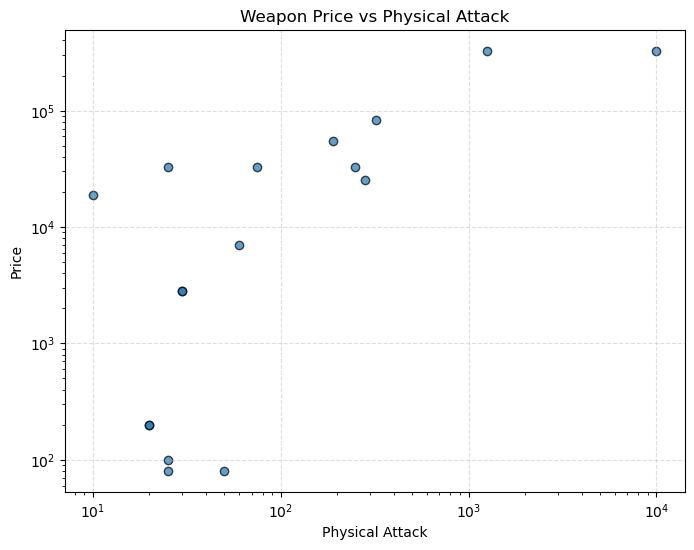

In [81]:
# Write the code to run functions to get each data visualization in separate code chunks. 
# Interpret the figures. 
def plot_attack_vs_price(df, title="Weapon Price vs Physical Attack", log_scale=True):
    data = df.copy()
    data["physical_attack"] = pd.to_numeric(data["physical_attack"], errors="coerce")
    data["price"] = pd.to_numeric(data["price"], errors="coerce")
    data = data.dropna(subset=["physical_attack", "price"])

    plt.figure(figsize=(8,6))
    plt.scatter(data["physical_attack"], data["price"], alpha=0.7, edgecolor='k')
    plt.xlabel("Physical Attack")
    plt.ylabel("Price")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.4)

    if log_scale:
        plt.xscale("log")
        plt.yscale("log")

    plt.show()



plot_attack_vs_price(weapons_df)


## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering. 

In [8]:
# list all the functions you have for modeling. Make sure write full 
# docstrings for each function
def fit_linear(df, y_feat, x_feat):

    pass

#### Model 1

In [9]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

#### Model 2

In [10]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

#### Model 3

In [11]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.